I only wanted to draw a frame around my Matplotlib figure. Instead, I discovered that Ipython matplotlib-inline backend and the `layout` parameter called from within the MPL code override each other in a confusing way. Also, the `layout = tight` does not lead to the same result when called from the inline backend and when called from MPL. 

In [1]:
import matplotlib.pyplot as plt 
from matplotlib.patches import Rectangle 
from matplotlib.lines import Line2D

import matplotlib as mpl 
print("MPL: {}".format(mpl.__version__))

import IPython as Ipt
print("IPython: {}".format(Ipt.__version__))

MPL: 3.6.1
IPython: 8.2.0



There are at least 2 ways to draw a frame around the whole chart:  

- modify the figure appearance using `f.set_edgecolor()` + `f.set_linewidth()` (default linewidth is zero) 
- create a new rectangle and add it to the figure children. 

This is how you can add rectangles to the figure itself: to use the figure coordinates, use the `transform` parameter. After creating a new rectangle object, add it to `f.patches`. 

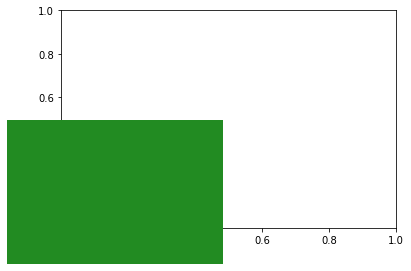

In [2]:
f, ax = plt.subplots()

# rectangle covering the bottom left quarter of the figure: 
ar = Rectangle(xy=(0,0), width=0.5, height=0.5, 
               transform=f.transFigure, 
               facecolor='forestgreen')
f.patches.extend([ar])

However, the longer I tried to reconcile the two functionalities, the longer I got confused. Let me show you. 

Let's define a function that will create an example chart. To be able to distinguish between different artists on the chart, I will: 

- color the <span style="background:cornsilk; border: 2px forestgreen solid !important;">chart background</span> as yellow and draw a green frame around it 
- add an extra <span style="border: 2px red dotted !important; ">red rectangle that should cover the whole figure</span>  (from (0,0) to (1,1) in figure coordinates) 
- add a <span style="border-bottom: 2px dodgerblue solid !important; ">blue line that should go across the whole figure</span> (from (0,0) to (1,1) in figure coordinates) 

In [3]:
#| code-fold: true
#| code-summary: "def ugly_chart(layout_kw={}):"

def ugly_chart(layout_kw={}):
    
    # initialize the figure with a default layout 
    f, ax = plt.subplots(figsize=(5,3), dpi=100, **layout_kw)
    
    # style a patch which is automatically created with the figure - it is a yellow rectangle that serves as a figure background 
    f.set_edgecolor('forestgreen')
    f.set_linewidth(2)
    f.set_facecolor('cornsilk')

    # add a rectangle with a red frame that should extend from (0,0) to (1,1) in figure coordinates
    ar = Rectangle(xy=(0,0), width=1, height=1, transform=f.transFigure,  
                   facecolor="none", 
                   linewidth=5, edgecolor='red', linestyle=':')
    f.patches.extend([ar])

    # add a line that should extend from (0,0) to (1,1) in figure coordinates
    l1 = Line2D([0, 1], [0, 1], transform=f.transFigure, color='dodgerblue')
    f.lines.extend([l1])
    
    print("bbox of the yellow background patch: {}".format(f.get_children()[0].get_bbox()))
    print("bbox of the red dotted rectangle box: {}".format(ar.get_bbox()))
    
    return f, ax

Let's inspect the chart that has been drawn as a result. The red and yellow rectangles do not overlap, although their bboxes are technically the same and should correspond to the same artist and same coordinate system! 

bbox of the yellow background patch: Bbox(x0=0.0, y0=0.0, x1=1.0, y1=1.0)
bbox of the red dotted rectangle box: Bbox(x0=0.0, y0=0.0, x1=1.0, y1=1.0)


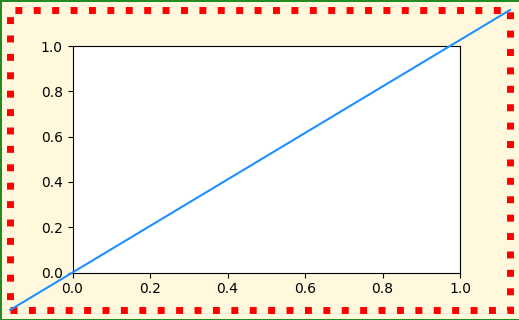

In [4]:
ugly_chart();

Also notice how the right green border got cut out of the image. The bottom green border is visible only partially (I believe this is because the bottom border is 1px off, and right border 2px off).

Now we can preview what we would have obtained if we saved the figure to png. Here let's stream the MPL output to the buffer and display the buffer. Since the original function will also show us the chart, let's modify the original chart *after* we exported it, so that we can distinguish the two:

bbox of the yellow background patch: Bbox(x0=0.0, y0=0.0, x1=1.0, y1=1.0)
bbox of the red dotted rectangle box: Bbox(x0=0.0, y0=0.0, x1=1.0, y1=1.0)


Text(0.5, 1.0, 'original chart')

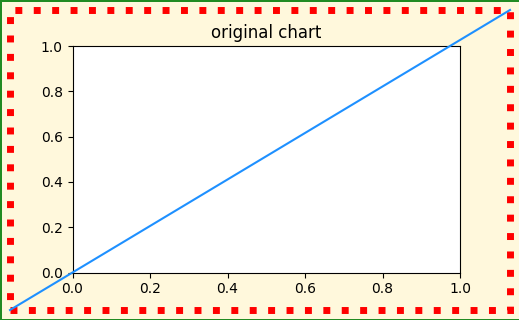

In [5]:
from io import BytesIO
f, ax = ugly_chart();

# export to buffer 
buf = BytesIO()
f.savefig(buf, format="png")

# modify and show the original chart 
ax.set_title('original chart')

And the exported chart would look like this:  

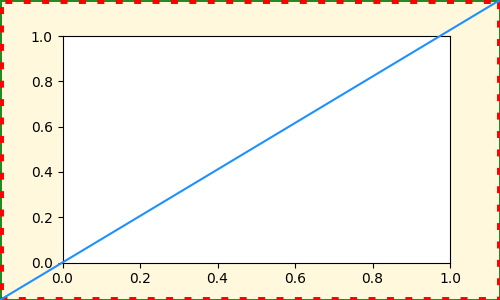

In [6]:
# display the buffer - output of savefig 
from IPython.display import Image 
Image(buf.getvalue())

WTF? It seems that the savefig does everything properly! But I mostly work with Jupyter interactively, so I do need the inline backend to work properly. So what is happening?

After some digging, it turns out that the reason for this discrepancy is the [Ipython inline backend configuration](https://stackoverflow.com/questions/26714626/how-to-disable-bbox-inches-tight-when-working-with-matplotlib-inline-in-ipytho). Ipython silently sets all the plots to be rendered in tight layout. We can modify them with a magic command. However, keep in mind this will modify the MPL behavior **globally for all the plots in the current session**: 

bbox of the yellow background patch: Bbox(x0=0.0, y0=0.0, x1=1.0, y1=1.0)
bbox of the red dotted rectangle box: Bbox(x0=0.0, y0=0.0, x1=1.0, y1=1.0)


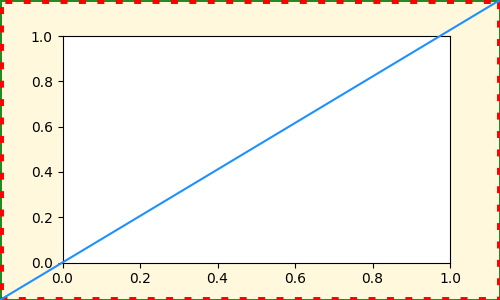

In [7]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
ugly_chart();

So we finally got what we wanted. For sanity, le't see what happens when we go back to the original setting: 

bbox of the yellow background patch: Bbox(x0=0.0, y0=0.0, x1=1.0, y1=1.0)
bbox of the red dotted rectangle box: Bbox(x0=0.0, y0=0.0, x1=1.0, y1=1.0)


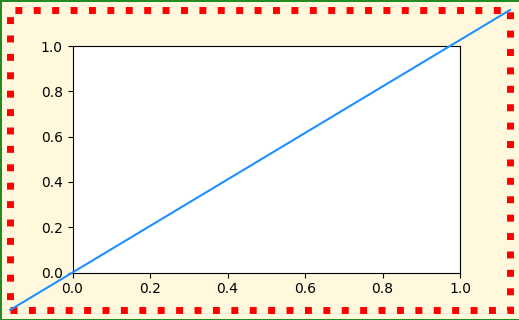

In [8]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}
ugly_chart();

It works as expected: I got back the initial (incorrect) result.

Now we can pass some keywords to the `plt.subplots()` inside the `ugly_chart()`. Let's try to override the layout setting that the IPython has set, by calling the `layout` parameter while initializing a figure: 

bbox of the yellow background patch: Bbox(x0=0.0, y0=0.0, x1=1.0, y1=1.0)
bbox of the red dotted rectangle box: Bbox(x0=0.0, y0=0.0, x1=1.0, y1=1.0)


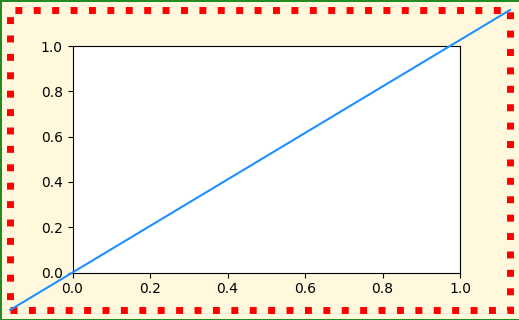

In [9]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}
ugly_chart({'layout': None});

bbox of the yellow background patch: Bbox(x0=0.0, y0=0.0, x1=1.0, y1=1.0)
bbox of the red dotted rectangle box: Bbox(x0=0.0, y0=0.0, x1=1.0, y1=1.0)


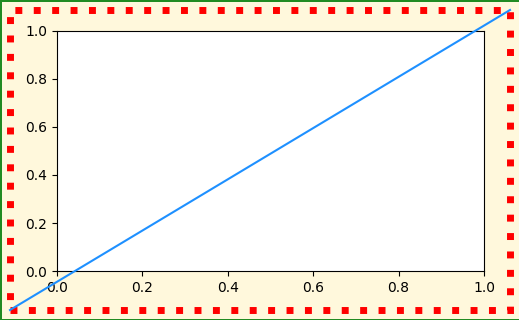

In [10]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}
ugly_chart({'layout': 'tight'});

It seems that the layout parameter passed to the keyword was ignored! WTF? 

And the other way round? 

bbox of the yellow background patch: Bbox(x0=0.0, y0=0.0, x1=1.0, y1=1.0)
bbox of the red dotted rectangle box: Bbox(x0=0.0, y0=0.0, x1=1.0, y1=1.0)


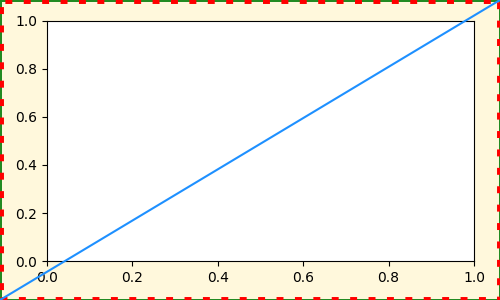

In [11]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
ugly_chart({'layout': 'tight'});

bbox of the yellow background patch: Bbox(x0=0.0, y0=0.0, x1=1.0, y1=1.0)
bbox of the red dotted rectangle box: Bbox(x0=0.0, y0=0.0, x1=1.0, y1=1.0)


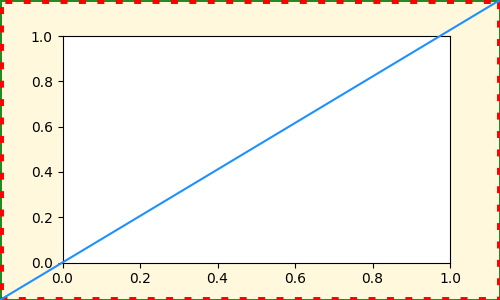

In [12]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
ugly_chart({'layout': 'none'});

So it looks like the IPython finally lets MPL use the layout parameter if the Inline backend layout is set to `None`. 

Anyway. Happy charting, everyone. 